# Measuring placebo effect on hunger

In this example we show show to measure the impact of placebo on hunger.

We model how hunger, $h(t)$, changes over time, $t$, over the course of $T$ hours, after taking a tablet, and given a communication based intervention, $i \in \{0, 1\}$.  
Each participant will do this twice with different $i$ interventions.

In [1]:

import os

import jax.random

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"
from jax.config import config

config.update("jax_enable_x64", True)
import numpy as np
import tensorflow_probability.substrates.jax as tfp
from jax import numpy as jnp

from jaxns import Prior

tfpd = tfp.distributions

/tmp/ipykernel_23374/661831631.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
INFO[2024-01-31 22:56:55,033]: Unable to initialize backend 'cuda': 
INFO[2024-01-31 22:56:55,033]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-01-31 22:56:55,034]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2024-01-31 22:56:55,035]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
from jaxns.framework.ops import simulate_prior_model
from jaxns import Model
from typing import NamedTuple

T = 3
dt_measure = 0.5
num_measurements = int(T / dt_measure) + 1
measure_times = np.linspace(0., T, num_measurements)
num_patients = 60

trial_mapping = dict()

count = 0
for day in [0, 1]:
    intervention = day == 1
    for patient_id in range(num_patients):
        trial_mapping[count] = (patient_id, day, intervention)
        count += 1

num_trials = len(trial_mapping)

intervention_mask = np.zeros((num_trials,), np.bool_)

for idx, (patient_id, day, intervention) in trial_mapping.items():
    if intervention:
        intervention_mask[idx] = True


class Params(NamedTuple):
    mean_hunger: jnp.ndarray  # mean hunger(t)


def prior_model():
    noise_scale = yield Prior(tfpd.TruncatedNormal(1., 0.5, low=0.5, high=2.), name='noise_scale')

    prior_h0_mean = yield Prior(tfpd.TruncatedNormal(5., 2., low=0., high=10.), name='prior_h0_mean')
    prior_h0_scale = yield Prior(tfpd.Uniform(0.5, 3.), name='prior_h0_scale')

    prior_h_change_per_hour = yield Prior(tfpd.Uniform(0.5, 2.))
    prior_h_change_control = yield Prior(prior_h_change_per_hour * T, name='prior_h_change_control')

    prior_h_change_intervention_factor = yield Prior(tfpd.Uniform(0.1, 1.), name='prior_h_change_intervention_factor')
    prior_h_change_intervention = prior_h_change_intervention_factor * prior_h_change_control

    # Choose right change for intervention.
    prior_h_change = jnp.where(intervention_mask, prior_h_change_intervention, prior_h_change_control)

    h0 = yield Prior(tfpd.TruncatedNormal(prior_h0_mean, prior_h0_scale,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"h0")
    hT = yield Prior(tfpd.TruncatedNormal(h0 + prior_h_change, 1.,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"hT")
    mean_hunger = h0[:, None] + measure_times * (hT[:, None] - h0[:, None]) / T
    patient_params = Params(
        mean_hunger=mean_hunger
    )
    return patient_params, noise_scale

# Simulate Data

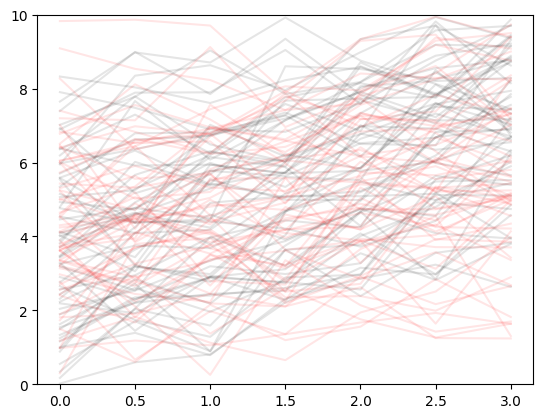

In [3]:


(patient_params, noise_scale), collected_params = simulate_prior_model(key=jax.random.PRNGKey(42),
                                                                       prior_model=prior_model)

measured_hunger = tfpd.TruncatedNormal(patient_params.mean_hunger, noise_scale, low=0., high=10.).sample(
    seed=jax.random.PRNGKey(42))


def log_likelihood(patient_params: Params, noise_scale):
    return jnp.sum(tfpd.TruncatedNormal(patient_params.mean_hunger, noise_scale,
                                        low=0., high=10.).log_prob(measured_hunger)
                   )


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)
import pylab as plt

plt.plot(measure_times, measured_hunger[~intervention_mask, :].T, c='k', alpha=0.1)
plt.plot(measure_times, measured_hunger[intervention_mask, :].T, c='r', alpha=0.1)
plt.ylim(0., 10.)
plt.show()


# Define likelihood
     

# Make a model that is unaware of the effect

In [4]:

def unaware_prior_model():
    noise_scale = yield Prior(tfpd.TruncatedNormal(1., 0.5, low=0.5, high=2.), name='noise_scale')

    prior_h0_mean = yield Prior(tfpd.TruncatedNormal(5., 2., low=0., high=10.), name='prior_h0_mean')
    prior_h0_scale = yield Prior(tfpd.Uniform(0.5, 3.), name='prior_h0_scale')

    prior_h_change_per_hour = yield Prior(tfpd.Uniform(0.5, 2.))
    prior_h_change_control = yield Prior(prior_h_change_per_hour * T, name='prior_h_change_control')

    prior_h_change = prior_h_change_control

    h0 = yield Prior(tfpd.TruncatedNormal(prior_h0_mean, prior_h0_scale,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"h0").parametrised()
    hT = yield Prior(tfpd.TruncatedNormal(h0 + prior_h_change, 1.,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"hT").parametrised()
    mean_hunger = h0[:, None] + measure_times * (hT[:, None] - h0[:, None]) / T
    patient_params = Params(
        mean_hunger=mean_hunger
    )
    return patient_params, noise_scale


unaware_model = Model(prior_model=unaware_prior_model, log_likelihood=log_likelihood)

In [5]:
from jaxns.experimental import EvidenceMaximisation

em = EvidenceMaximisation(model=unaware_model, ns_kwargs=dict(max_samples=1e5), max_num_epochs=10, gtol=0.1, momentum=0.)


Convergence achieved at step 6.:  60%|██████    | 6/10 [04:21<02:54, 43.53s/it]                                                                                                                                                                                                      


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 243243
samples: 2880
phantom samples: 0
likelihood evals / sample: 84.5
phantom fraction (%): 0.0%
--------
logZ=-896.67 +- 0.33
H=-13.29
ESS=282
--------
h0[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
h0[0]: 4.867 +- 0.044 | 4.812 / 4.867 / 4.922 | 4.863 | 4.871
h0[1]: 1.793 +- 0.059 | 1.72 / 1.795 / 1.867 | 1.792 | 1.796
h0[2]: 6.931 +- 0.058 | 6.855 / 6.934 / 7.011 | 6.926 | 6.936
h0[3]: 3.692 +- 0.045 | 3.633 / 3.692 / 3.748 | 3.689 | 3.696
h0[4]: 3.76 +- 0.044 | 3.7 / 3.76 / 3.816 | 3.757 | 3.763
h0[5]: 3.305 +- 0.046 | 3.243 / 3.307 / 3.362 | 3.303 | 3.309
h0[6]: 7.187 +- 0.061 | 7.105 / 7.19 / 7.271 | 7.181 | 7.192
h0[7]: 5.434 +- 0.046 | 5.379 / 5.433 / 5.494 | 5.43 | 5.438
h0[8]: 4.783 +- 0.044 | 4.728 / 4.782 / 4.838 | 4.779 | 4.787
h0[9]: 0.927 +- 0.068 | 0.839 / 0.932 / 1.015 | 0.926 | 0.93
h0[10]: 4.334 +- 0.043 | 4.276 / 4.336 / 4.39 | 4.331 | 4.338
h0[11]: 1.

/home/albert/git/jaxns/jaxns/plotting.py:47: RuntimeWarning: divide by zero encountered in divide
  efficiency = 1. / num_likelihood_evaluations_per_sample


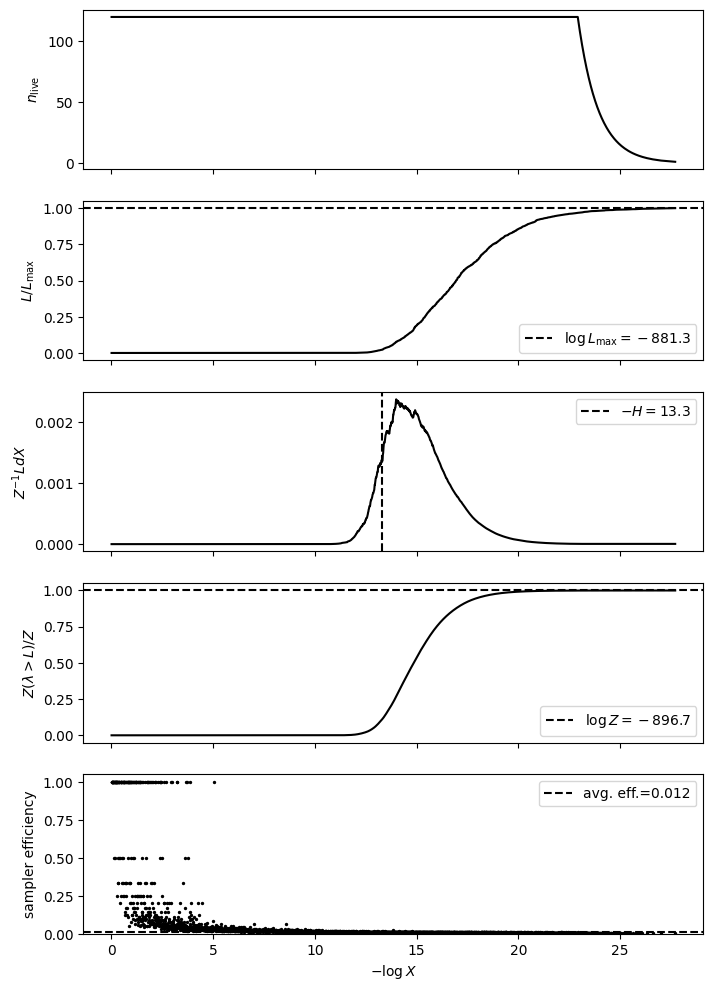

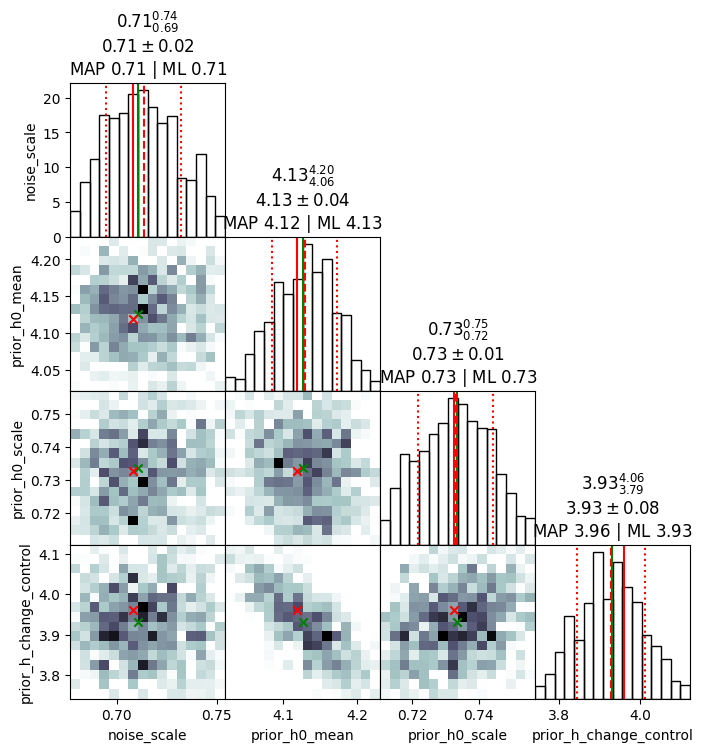

In [6]:
from jaxns import summary, plot_diagnostics, plot_cornerplot

ns_results, params = em.train(num_steps=10)
summary(ns_results, with_parametrised=True)
plot_diagnostics(ns_results)
plot_cornerplot(ns_results, variables=['noise_scale', 'prior_h0_mean', 'prior_h0_scale', 'prior_h_change_control'],
                with_parametrised=True)

In [7]:

def aware_prior_model():
    noise_scale = yield Prior(tfpd.TruncatedNormal(1., 0.5, low=0.5, high=2.), name='noise_scale')

    prior_h0_mean = yield Prior(tfpd.TruncatedNormal(5., 2., low=0., high=10.), name='prior_h0_mean')
    prior_h0_scale = yield Prior(tfpd.Uniform(0.5, 3.), name='prior_h0_scale')

    prior_h_change_per_hour = yield Prior(tfpd.Uniform(0.5, 2.))
    prior_h_change_control = yield Prior(prior_h_change_per_hour * T, name='prior_h_change_control')

    prior_h_change_intervention_factor = yield Prior(tfpd.Uniform(0.1, 1.), name='prior_h_change_intervention_factor')
    prior_h_change_intervention = prior_h_change_intervention_factor * prior_h_change_control

    # Choose right change for intervention.
    prior_h_change = jnp.where(intervention_mask, prior_h_change_intervention, prior_h_change_control)

    h0 = yield Prior(tfpd.TruncatedNormal(prior_h0_mean, prior_h0_scale,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"h0").parametrised()
    hT = yield Prior(tfpd.TruncatedNormal(h0 + prior_h_change, 1.,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"hT").parametrised()
    mean_hunger = h0[:, None] + measure_times * (hT[:, None] - h0[:, None]) / T
    patient_params = Params(
        mean_hunger=mean_hunger
    )
    return patient_params, noise_scale


aware_model = Model(prior_model=aware_prior_model, log_likelihood=log_likelihood)


Convergence achieved at step 5.:  50%|█████     | 5/10 [04:21<04:21, 52.24s/it]                                                                                                                                                                                                      


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 364993
samples: 3900
phantom samples: 0
likelihood evals / sample: 93.6
phantom fraction (%): 0.0%
--------
logZ=-899.07 +- 0.32
H=-15.19
ESS=412
--------
h0[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
h0[0]: 4.876 +- 0.043 | 4.825 / 4.876 / 4.931 | 4.852 | 4.873
h0[1]: 1.789 +- 0.057 | 1.715 / 1.789 / 1.865 | 1.779 | 1.784
h0[2]: 6.927 +- 0.055 | 6.861 / 6.933 / 6.992 | 6.894 | 6.926
h0[3]: 3.69 +- 0.044 | 3.635 / 3.689 / 3.748 | 3.671 | 3.686
h0[4]: 3.76 +- 0.044 | 3.706 / 3.76 / 3.818 | 3.741 | 3.757
h0[5]: 3.313 +- 0.046 | 3.254 / 3.313 / 3.371 | 3.295 | 3.309
h0[6]: 7.183 +- 0.057 | 7.113 / 7.19 / 7.248 | 7.149 | 7.182
h0[7]: 5.439 +- 0.045 | 5.385 / 5.441 / 5.495 | 5.413 | 5.437
h0[8]: 4.785 +- 0.043 | 4.735 / 4.784 / 4.84 | 4.761 | 4.782
h0[9]: 0.92 +- 0.065 | 0.838 / 0.917 / 1.003 | 0.913 | 0.914
h0[10]: 4.374 +- 0.043 | 4.323 / 4.375 / 4.431 | 4.353 | 4.371
h0[11]:

/home/albert/git/jaxns/jaxns/plotting.py:47: RuntimeWarning: divide by zero encountered in divide
  efficiency = 1. / num_likelihood_evaluations_per_sample


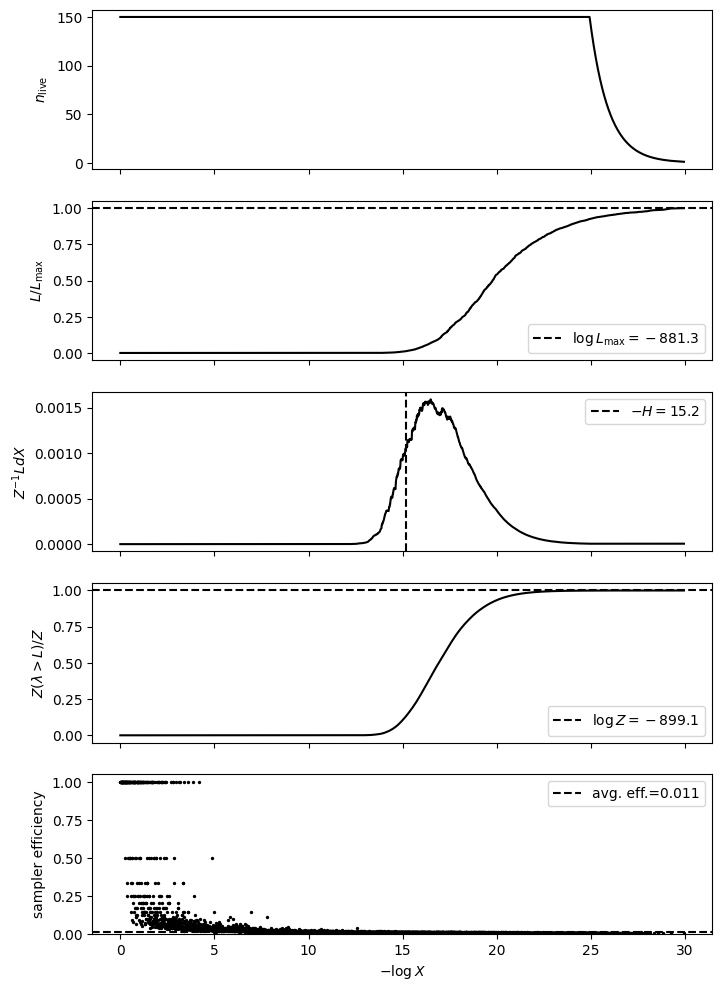

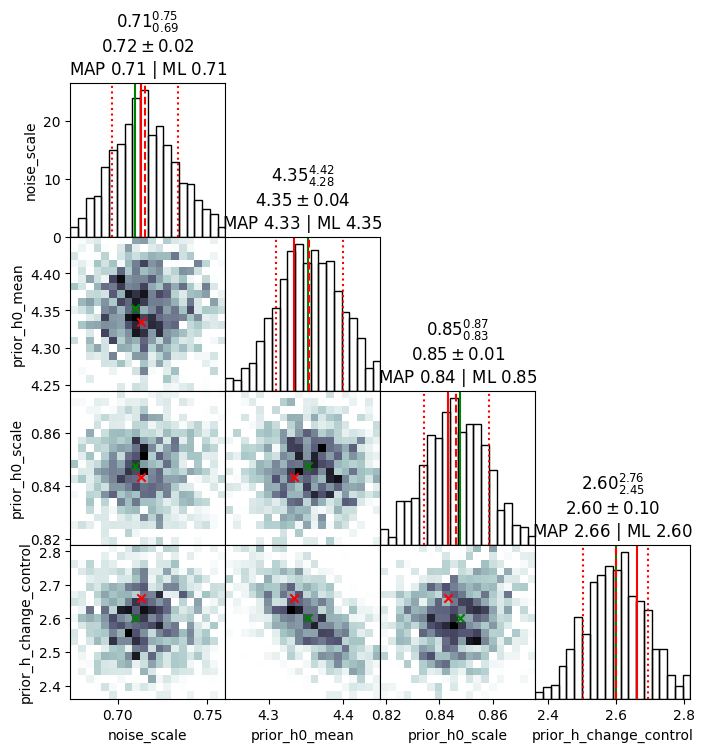

In [8]:
em = EvidenceMaximisation(model=aware_model, ns_kwargs=dict(max_samples=1e5), max_num_epochs=10, gtol=0.1, momentum=0.)

ns_results, params = em.train(num_steps=10)
summary(ns_results, with_parametrised=True)
plot_diagnostics(ns_results)
plot_cornerplot(ns_results, variables=['noise_scale', 'prior_h0_mean', 'prior_h0_scale', 'prior_h_change_control','prior_h_change_intervention_factor'],
                with_parametrised=True)
